In [1]:
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkContext, SQLContext
sc = pyspark.SparkContext('local[*]')
sqlc = SQLContext(sc)

In [2]:
%matplotlib inline
from pyspark.sql import functions as F, Window
from pyspark.sql.functions import *


In [3]:
import numpy as np

### Load data for stars made in 2017

In [6]:
stars=sqlc.read.json('./data/watchers_2017.json')

In [6]:
stars.count() #4.569.604 total stars

4569604

In [4]:
stars.select('w_repo_id').distinct().count() #843.398 unique stars

843398

In [5]:
stars.select('w_user_id').distinct().count() #973.519 distinct users

973519

In [7]:
stars.describe().toPandas()  #6.2 stars per user on avg

,summary,w_created_at,w_repo_id,w_user_id
0,count,4569604,4569604,4569604
1,mean,None,6.238284356101448E7,1.0894306226322018E7
2,stddev,None,5336706.25312665,1.2306703006119143E7
3,min,2008-02-13 12:57:00 UTC,53834267,1
4,max,2017-08-31 23:59:54 UTC,73522310,999997


### Load data from forks and original repositories made in 2017

In [8]:
origin=sqlc.read.json('./data/projects_not_forked_2017.json')

In [9]:
forks=sqlc.read.json('./data/projects_forked_2017.json')

In [88]:
##join_stars=stars.join(origin, origin.id==stars.w_repo_id,'inner')

In [89]:
##join_stars.select('id').distinct().count() #648.387 stars comes from original projects made in 2017

648387

In [90]:
##join_stars=watchers.join(forks,forks.id==watchers.w_repo_id,'inner')

#### CHECK THIS PART!

In [91]:
##join_test2.select('id').distinct().count() #195.011 stars comes from forks made in 2017 

191823

In [92]:
#in total 648.387+195.011=843.398 OK! We will consider only stars from original projects

### Consider only stars to repositories contained in "origin"

In [10]:
orig_select=origin.select(col('id').alias('orig_id'),col('language').alias('orig_language'),col('owner_id').alias('orig_user'))

stars_orig=stars.join(orig_select, orig_select.orig_id==stars.w_repo_id,'inner')

In [37]:
stars_orig.count() #4.294.731 total stars

4294731

In [38]:
stars_orig.select('w_repo_id').distinct().count() #648.387 unique stars

648387

In [39]:
stars_orig.select('w_user_id').distinct().count() #927.678 distinct users

927678

### Distribution of users by number of stars

In [12]:
stars_by_user=stars_orig.groupby('w_user_id').agg(F.count('w_repo_id').alias('total_stars'))

In [41]:
stars_by_user.describe().toPandas()

,summary,w_user_id,total_stars
0,count,927678,927678
1,mean,1.5387119778390778E7,4.629549261705031
2,stddev,1.4079101972667035E7,24.614130402753627
3,min,1,1
4,max,999997,15010


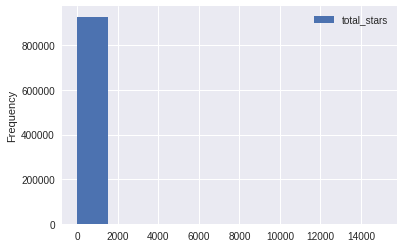

In [9]:
stars_by_user.select('total_stars').toPandas().plot.hist()

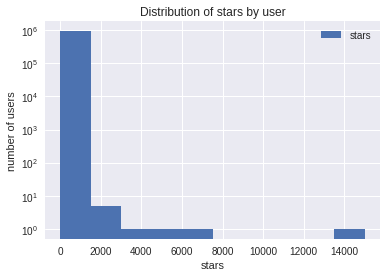

In [14]:
stars_by_user.select(col('total_stars').alias('stars')).toPandas().plot.hist(log=True,title='Distribution of stars by user') #1 user has 14.000 stars
plt.xlabel('stars')
plt.ylabel('number of users')
plt.savefig('dist_forks_log.png')

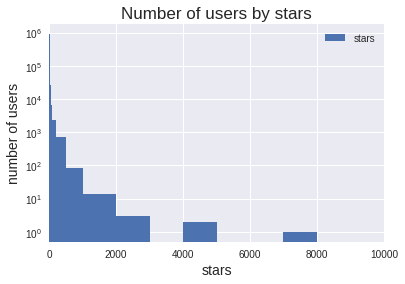

In [15]:
stars_by_user.select(col('total_stars').alias('stars')).toPandas().plot.hist(log=True,\
                    xlim=(0,10000),bins=[0,20,50,100,200,500,1000,2000,3000,4000,5000,6000,7000,8000,9000]) #1 user has 14.000 stars
plt.xlabel('stars', fontsize=14)
plt.ylabel('number of users', fontsize=14)
plt.title('Number of users by stars', fontsize=17)

plt.savefig('dist_stars_bins_log.png')

### Consider only forks to repositories contained in "origin"

In [10]:
forks_orig=forks.join(orig_select, orig_select.orig_id==forks.forked_from,'inner')

In [96]:
forks_orig.count() #1.375.653 total forks 

1375653

#### Remove duplicates (i.e. repositories that have been forked multiple times by the same user)

In [98]:
forks_orig.groupby('owner_id','orig_id','forked_from').agg(F.count('*').alias('r')).filter('r>1').show()

+--------+--------+-----------+---+
|owner_id| orig_id|forked_from|  r|
+--------+--------+-----------+---+
|10109572|55217278|   55217278|  2|
|35554902|58567876|   58567876|  2|
|35188846|58567876|   58567876|  2|
|11660758|59065130|   59065130|  2|
| 6137643|59168695|   59168695|  3|
|10143502|59231268|   59231268|  2|
| 1481821|60496584|   60496584|  2|
|21715436|60671768|   60671768|  2|
|34101342|60988565|   60988565|  2|
| 6399461|61575081|   61575081|  2|
|   85910|61653260|   61653260|  2|
| 7796718|61708417|   61708417|  2|
|32262663|62633069|   62633069|  2|
| 1789555|63060371|   63060371|  2|
|33285444|63554986|   63554986|  2|
|11916204|63554986|   63554986|  2|
| 4004022|64311561|   64311561|  2|
|10964790|65736084|   65736084|  2|
| 3525627|68160466|   68160466|  2|
|35404105|68938329|   68938329|  2|
+--------+--------+-----------+---+
only showing top 20 rows



In [11]:
forks_orig=forks_orig.sort('owner_id','created_at',ascending=True)

In [ ]:
forks_orig=forks_orig.dropDuplicates(['owner_id','forked_from'])

In [103]:
forks_orig.count() # 1.364.300 total forks

1364300

In [104]:
forks_orig.select('forked_from').distinct().count() #469.800 unique forks

469800

In [105]:
forks_orig.select('owner_id').distinct().count() #663.788 users

663788

### Distribution of users by number of forks

In [12]:
forks_by_user=forks_orig.groupby('owner_id').agg(F.count('forked_from').alias('total_forks'))

In [107]:
forks_by_user.describe().toPandas()

,summary,owner_id,total_forks
0,count,663788,663788
1,mean,1.971116379725304E7,2.055324892887488
2,stddev,1.4438797216357991E7,9.644463780307506
3,min,1,1
4,max,99999,2833


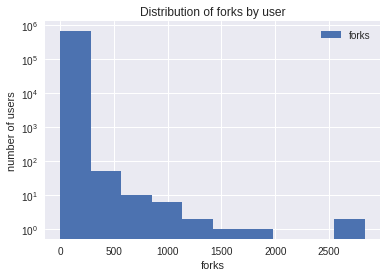

In [23]:
forks_by_user.select(col('total_forks').alias('forks')).toPandas().plot.hist(log=True,title='Distribution of forks by user') #1 user has 14.000 stars
plt.xlabel('forks')
plt.ylabel('number of users')
plt.savefig('dist_forks_log.png')

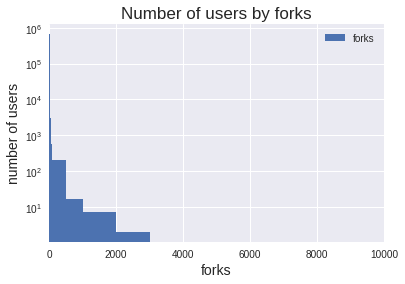

In [16]:
forks_by_user.select(col('total_forks').alias('forks')).toPandas().plot.hist(log=True,\
                         xlim=(0,10000),bins=[0,20,50,100,200,500,1000,2000,3000,4000,5000,6000,7000,8000,9000]) #1 user has 14.000 stars
plt.xlabel('forks', fontsize=14)
plt.ylabel('number of users', fontsize=14)
plt.title('Number of users by forks', fontsize=17)
plt.savefig('dist_forks_bins_log.png')

In [16]:
sc.stop()